[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Time to build vocab: 0.0 mins
Time to train the model: 0.15 mins
Epoch 1/10
----------
Epoch 1/10, Loss: 1.107447255741466, Accuracy: 0.28183118741058655
Epoch 2/10
----------
Epoch 2/10, Loss: 1.0948943333192305, Accuracy: 0.3719599427753934
Epoch 3/10
----------
Epoch 3/10, Loss: 1.0826794342561201, Accuracy: 0.5078683834048641
Epoch 4/10
----------
Epoch 4/10, Loss: 1.0706232569434426, Accuracy: 0.592274678111588
Epoch 5/10
----------
Epoch 5/10, Loss: 1.0586943518031726, Accuracy: 0.6680972818311874
Epoch 6/10
----------
Epoch 6/10, Loss: 1.0468661134893245, Accuracy: 0.721030042918455
Epoch 7/10
----------
Epoch 7/10, Loss: 1.0351129120046443, Accuracy: 0.7625178826895566
Epoch 8/10
----------
Epoch 8/10, Loss: 1.023411436514421, Accuracy: 0.7753934191702432
Epoch 9/10
----------
Epoch 9/10, Loss: 1.011740662834861, Accuracy: 0.7882689556509299
Epoch 10/10
----------

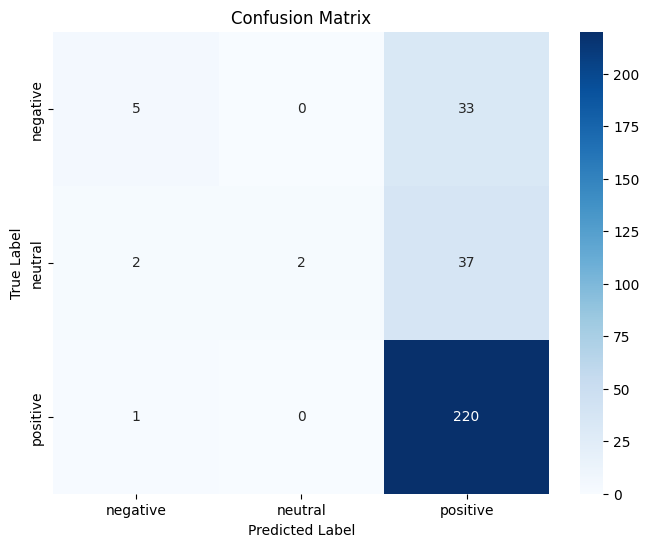

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from time import time
import math

# Load dataset
data_path = '/kaggle/input/tripadvisor-1000-dataset-examples/trip-advisor-copy.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
nltk.download('punkt')

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

data['Cleaned_Review'] = data['Review'].apply(clean_text)

# Adjust labels for sentiment analysis
data['Sentiment'] = pd.cut(data['Rating'], bins=[-np.inf, 2, 3, np.inf], labels=['negative', 'neutral', 'positive'], right=False)

# Split data into train and test sets (70% train, 30% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'], data['Sentiment'], test_size=0.3, random_state=42)

# Convert text data to TaggedDocuments for Doc2Vec
documents = [TaggedDocument(nltk.word_tokenize(text.lower()), [i]) for i, text in enumerate(data['Cleaned_Review'])]

# Train Doc2Vec model
cores = multiprocessing.cpu_count()
d2v_model = Doc2Vec(vector_size=300,
                    window=2,
                    min_count=2,
                    workers=cores-1,
                    epochs=40)

t = time()
d2v_model.build_vocab(documents)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()
d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# Convert text data to Doc2Vec vectors
def text_to_vector(text):
    return d2v_model.infer_vector(nltk.word_tokenize(text.lower()), alpha=0.1, min_alpha=0.0001)

train_vectors = np.array([text_to_vector(text) for text in train_texts])
test_vectors = np.array([text_to_vector(text) for text in test_texts])

# Define BiLSTM with attention model
class Attention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim):
        super(Attention, self).__init__()
        self.scale = 1. / math.sqrt(query_dim)

    def forward(self, query, keys, values):
        query = query.unsqueeze(1)  # [BxQ] -> [Bx1xQ]
        keys = keys.permute(0, 2, 1)  # [BxTxK] -> [BxKxT]
        energy = torch.bmm(query, keys)  # [Bx1xQ]x[BxKxT] -> [Bx1xT]
        energy = torch.nn.functional.softmax(energy.mul_(self.scale), dim=2)  # scale, normalize

        linear_combination = torch.bmm(energy, values).squeeze(1)  # [Bx1xT]x[BxTxV] -> [BxV]
        return energy, linear_combination

class SentimentBiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SentimentBiLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2, hidden_size * 2, hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # hidden_size * 2 for bidirectional

    def forward(self, x):
        bilstm_out, (hn, cn) = self.bilstm(x)
        bilstm_out = bilstm_out.contiguous()  # Ensure the tensor is contiguous
        # Pass the entire sequence to the attention mechanism
        query = hn.transpose(0, 1).contiguous().view(x.size(0), -1)
        keys = bilstm_out
        values = bilstm_out
        energy, linear_combination = self.attention(query, keys, values)
        output = self.fc(linear_combination)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentBiLSTMWithAttention(input_size=300, hidden_size=128, output_size=len(data['Sentiment'].unique()))
model = model.to(device)

class ReviewDataset(Dataset):
    def __init__(self, reviews, vectors, ratings):
        self.reviews = reviews
        self.vectors = vectors
        self.ratings = ratings

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        vector = self.vectors[idx]
        rating = self.ratings.iloc[idx]
        return {
            'vector': torch.tensor(vector, dtype=torch.float).unsqueeze(0),  # Add an extra dimension for the LSTM
            'labels': torch.tensor(0 if rating == 'negative' else 1 if rating == 'neutral' else 2, dtype=torch.long)  # Adjusted labels
        }

def create_data_loader(reviews, vectors, ratings, batch_size):
    ds = ReviewDataset(reviews, vectors, ratings)
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

BATCH_SIZE = 64  # Change batch size to 64
train_data_loader = create_data_loader(train_texts, train_vectors, train_labels, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_vectors, test_labels, BATCH_SIZE)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training loop
EPOCHS = 10  # Set the number of epochs to 10

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        vectors = d["vector"].to(device)
        labels = d["labels"].to(device)

        outputs = model(vectors)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Main training loop with epoch print statements
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        len(train_texts)
    )

    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss}, Accuracy: {train_acc}')

def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            vectors = d["vector"].to(device)
            labels = d["labels"].to(device)

            outputs = model(vectors)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    return torch.stack(predictions).cpu(), torch.stack(real_values).cpu()

y_pred, y_true = get_predictions(model, test_data_loader)

# Evaluate model
def evaluate_model(model, test_vectors_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(test_vectors_tensor)  # No need to add extra dimension for batch
        _, predicted = torch.max(outputs, 1)
        cm = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        cr = classification_report(test_labels_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
    return cm, cr

# Convert test data to tensor
test_vectors_tensor = torch.tensor(test_vectors, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels.cat.codes.values, dtype=torch.long).to(device)

# Evaluate the BiLSTM with attention model
conf_matrix, class_report = evaluate_model(model, test_vectors_tensor, test_labels_tensor)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix, ['negative', 'neutral', 'positive'])
